# Taxi time Estimations

### Víctor Pimentel 




In [13]:
# Import libraries 
import pandas as pd 
import numpy as np 
import xgboost as xgb
import matplotlib.pyplot as plt
import geopy
import seaborn as sns
import lightgbm
import calendar
from sklearn.preprocessing import LabelEncoder

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [28]:
train

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
0               -73.964630         40.765602                  N            455  
1               -73.999481         40.731152                  N            663  
2               -74.005333         40.710087                  N           2124  
3               -74.012268         40.706718                  N            429  
4               -73.972923         40.782520                  N            435  
...                    ...               ...                ...            ...  
1458639         -73.994911         40.740170                  N            778  
1458640         -73.970184         40.796547                  N            655  
1458641         -74.004433         40.707371                  N            764  
1458642         -73.974632         40.757107                  N            373  
1458643         -73.972809         40.790585                  N            198  

[1458644 rows x 11 columns]

# __Data Preprocessing__

In [29]:
# Dates formating into new variables

# Train Set
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x : x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x : x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x : calendar.day_name[x.weekday()])

# Train for Visualize
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x : x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x : x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x : calendar.day_name[x.weekday()])

# Test Set
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x : x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x : x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x : calendar.day_name[x.weekday()])


In [30]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x : round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x : round(x, 3))
train['dropoff_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x, 3))

test['pickup_latitude_round3'] = test['pickup_latitude'].apply(lambda x : round(x, 3))
test['pickup_longitude_round3'] = test['pickup_longitude'].apply(lambda x : round(x, 3))
test['dropoff_latitude_round3'] = test['dropoff_latitude'].apply(lambda x : round(x, 3))
test['dropoff_longitude_round3'] = test['pickup_longitude'].apply(lambda x : round(x, 3))

In [31]:
le = LabelEncoder()
le.fit(train['store_and_fwd_flag'])
train['store_and_fwd_flag'] = le.transform(train['store_and_fwd_flag'])
test['store_and_fwd_flag'] = le.transform(test['store_and_fwd_flag'])

In [32]:
def encodeDays(day_of_week):
    day_dict = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,
                'Friday':5, 'Saturday':6}
    return day_dict[day_of_week]

train['pickup_day_of_week'] = train['pickup_day_of_week'].apply(lambda x:encodeDays(x))
test['pickup_day_of_week'] = test['pickup_day_of_week'].apply(lambda x:encodeDays(x))

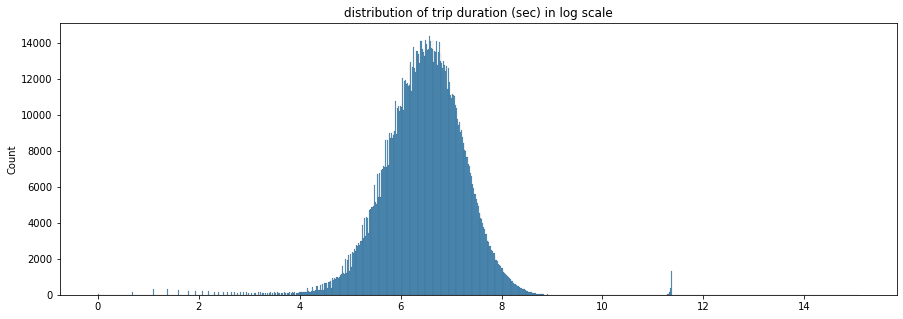

In [33]:
plt.figure(figsize = (15,5))
sns.histplot(np.log(train['trip_duration'].values)).set_title('distribution of trip duration')
plt.title('distribution of trip duration (sec) in log scale')
plt.show()

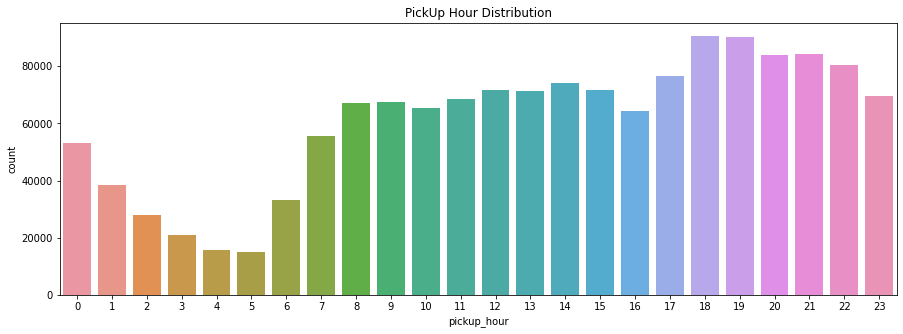

In [34]:
plt.figure(figsize = (15, 5))
sns.countplot(x = train["pickup_hour"]).set_title("PickUp Hour Distribution")
plt.show()

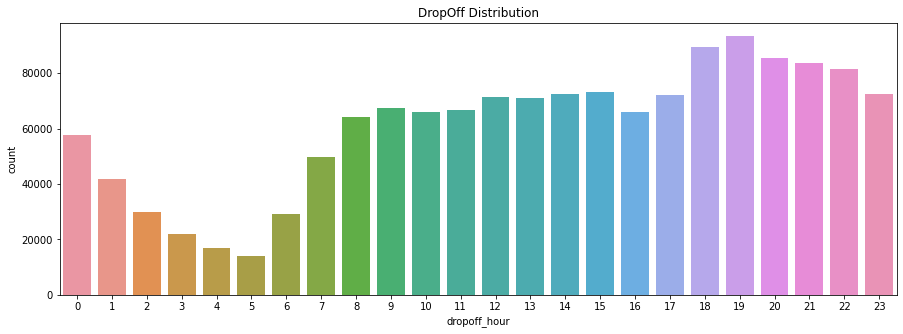

In [35]:
# Looking for Outliers
plt.figure(figsize = (15, 5))
sns.countplot(x = train["dropoff_hour"]).set_title("DropOff Distribution")
plt.show()

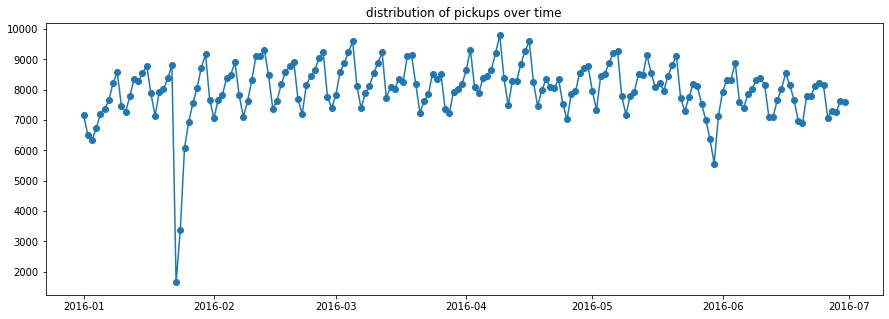

In [36]:
plt.figure(figsize = (15, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')

plt.title('distribution of pickups over time')
plt.show()

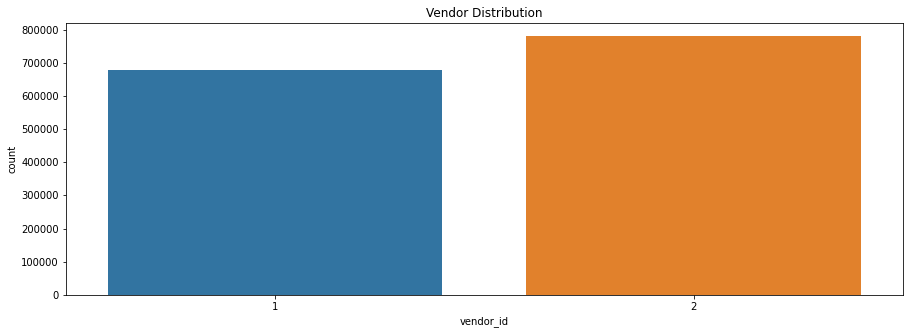

In [37]:
plt.figure(figsize = (15, 5))
sns.countplot(x = train["vendor_id"]).set_title("Vendor Distribution")
plt.show()

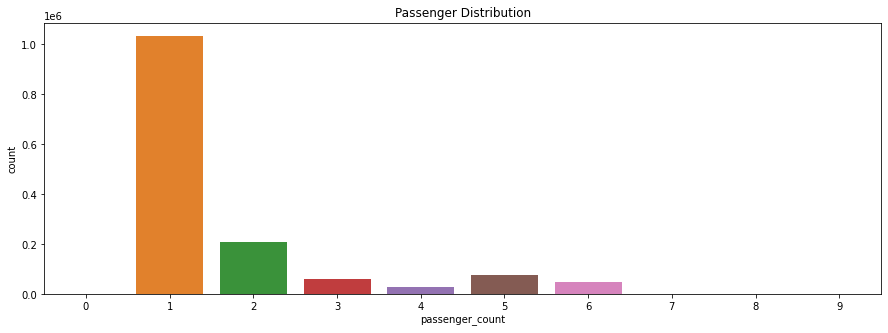

In [38]:
plt.figure(figsize = (15, 5))
sns.countplot(x = train["passenger_count"]).set_title("Passenger Distribution")
plt.show()

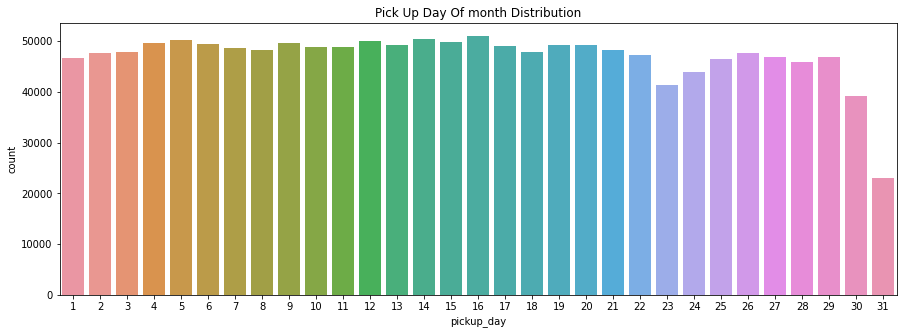

In [39]:
plt.figure(figsize = (15, 5))
sns.countplot(x = train["pickup_day"]).set_title("Pick Up Day Of month Distribution")
plt.show()

In [40]:
from geopy.distance import geodesic

# In geometry, a geodesic is commonly a curve representing in some sense the shortest path (arc) between two points in a surface, 
# or more generally in a Riemannian manifold. The term also has meaning in any differentiable manifold with a connection. 
# It is a generalization of the notion of a "straight line" to a more general setting.

def get_distance(row): 
    
    pick_lat = row["pickup_latitude"]
    pick_lon  = row["pickup_longitude"]

    drop_lat = row["dropoff_latitude"]
    drop_lon =  row["dropoff_longitude"]

    coordinates_pick = (pick_lat,pick_lon)
    coordinates_drop = (drop_lat, drop_lon)

    distance = geodesic(coordinates_pick, coordinates_drop)

    return distance.km


In [41]:
train["distance"] = train.apply(lambda row: get_distance(row), axis = 1)
test["distance"] = test.apply(lambda row: get_distance(row), axis = 1)

In [44]:
from sklearn.cluster import KMeans

# Basic Idea is that depending on where the client was picked up it converges into more time spend in travel 

coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                   train[['dropoff_latitude', 'dropoff_longitude']].values,
                   test[['pickup_latitude', 'pickup_longitude']].values,
                   test[['dropoff_latitude', 'dropoff_longitude']].values))

kmeans = KMeans(n_clusters = 10, random_state = 0).fit(coords)

train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 
                                                            'dropoff_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude',
                                                            'pickup_longitude']])

In [47]:
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 
                                                            'dropoff_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude',
                                                            'pickup_longitude']])

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

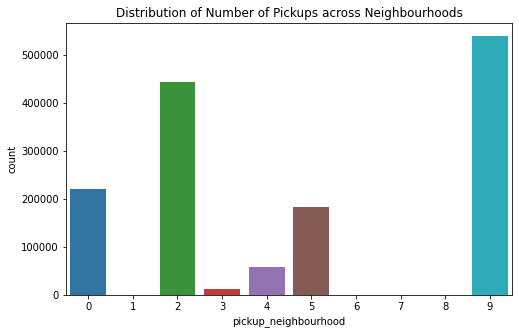

In [45]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

In [49]:
model_columns = [
    "vendor_id", 
    "passenger_count", 
    "pickup_latitude_round3",            
    "pickup_longitude_round3",            
    "dropoff_latitude_round3",          
    "dropoff_longitude_round3",
    "distance", 
    "pickup_neighbourhood", 
    "dropoff_neighbourhood", 
    "store_and_fwd_flag", 
    "pickup_day", 
    "pickup_hour", 
    "pickup_day_of_week"
]
target_column = [
    "trip_duration"
]

In [51]:
test[model_columns]

vendor_id  passenger_count  pickup_latitude_round3  \
0               1                1                  40.732   
1               1                1                  40.680   
2               1                1                  40.738   
3               2                1                  40.772   
4               1                1                  40.761   
...           ...              ...                     ...   
625129          1                1                  40.725   
625130          1                1                  40.744   
625131          1                2                  40.760   
625132          1                1                  40.734   
625133          2                2                  40.717   

        pickup_longitude_round3  dropoff_latitude_round3  \
0                       -73.988                   40.757   
1                       -73.964                   40.655   
2                       -73.997                   40.730   
3                       -73.956                   40.730   
4                       -73.970                   40.756   
...                         ...                      ...   
625129                  -74.003                   40.734   
625130                  -74.006                   40.782   
625131                  -73.972                   40.749   
625132                  -73.977                   40.892   
625133                  -73.982                   40.769   

        dropoff_longitude_round3   distance  pickup_neighbourhood  \
0                        -73.988   2.742863                     2   
1                        -73.964   2.755774                     5   
2                        -73.997   1.307112                     2   
3                        -73.956   5.266978                     9   
4                        -73.970   0.961745                     9   
...                          ...        ...                   ...   
625129                   -74.003   0.966304                     5   
625130                   -74.006   6.200637                     9   
625131                   -73.972   8.173789                     4   
625132                   -73.977  20.374287                     4   
625133                   -73.982   5.924957                     5   

        dropoff_neighbourhood  store_and_fwd_flag  pickup_day  pickup_hour  \
0                           9                   0          30           23   
1                           5                   0          30           23   
2                           2                   0          30           23   
3                           9                   0          30           23   
4                           9                   0          30           23   
...                       ...                 ...         ...          ...   
625129                      2                   0           1            0   
625130                      9                   0           1            0   
625131                      9                   0           1            0   
625132                      0                   0           1            0   
625133                      9                   0           1            0   

        pickup_day_of_week  
0                        4  
1                        4  
2                        4  
3                        4  
4                        4  
...                    ...  
625129                   5  
625130                   5  
625131                   5  
625132                   5  
625133                   5  

[625134 rows x 13 columns]

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[model_columns], train[target_column], test_size=0.33, random_state=42)

In [92]:
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.1,
    'max_depth':          14,
    'subsample':          0.8,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1
}

In [97]:
nrounds = 50

## train model
dtrain = xgb.DMatrix(X_train, np.log(y_train +1))
gbm = xgb.train(params, dtrain, num_boost_round=nrounds)

[00:08:58] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [98]:
test_pred = np.exp(gbm.predict(xgb.DMatrix(test[model_columns]))) - 1
test_id = test["id"]
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']= test_pred

submit.to_csv("submit_xgboost.csv", index = False)